In [1]:
# Dataset is from a DataCamp project: https://www.datacamp.com/projects/184.
# The data is about an A/B test from a mobile game Cookie Cats.
# A common metric in the video gaming industry for how fun and engaging a game is 1-day retention: 
# the percentage of players that comes back and plays the game one day after they have installed it. 
# The higher 1-day retention is, the easier it is to retain players and build a large player base.
# По мере прохождения игры игроки сталкиваются с воротами, которые заставляют их ждать некоторое время, прежде чем они смогут продвинуться или совершить покупку в приложении. 
# В этом проекте анализируется результат A/B-теста по метрике удержания игрока, в котором первые ворота Cookie Cats были перемещены с 30-го на 40-й уровень. 

# Сама игра Cookie Cats https://youtu.be/0G-612U2vQY

In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math 
import scipy.stats as st

### Загрузка датасета и первичный анализ признаков
Импортируем набор данных - в тестовой выборке участвовало 90189 наблюдений, доступны 5 столбцов: 

- userid - уникальный id игрока, участвующий в тесте

- version - метка, обозначающая тестовую (gate_40) или контрольную (gate_30) группу игроков

- sum_gamerounds - число сыгранных игорком игр в первую неделю после установки

- retention_1 - удержание игрока в игре на день 1 после установки

- retention_7 - удержание игрока в игре на день 7 после установки

Типы данных не нуждаются в оптимизации, пропусков нет, userid уникальный

In [162]:
DATASET_PATH = './datasets/cookie_cats.csv'
df = pd.read_csv(DATASET_PATH, sep=',')
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


In [163]:
df.shape

(90189, 5)

In [164]:
df.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [166]:
len(df['userid'].unique().tolist())

90189

In [167]:
# Из 90 тыс. наблюдений только 17 тыс. имеют удержание в игре на 7 день после установки приложения
df.loc[df["retention_7"] == True].shape[0]

16781

In [168]:
# Из 90 тыс. наблюдений только 40 тыс. имеют удержание в игре на 1 день после установки приложения
df.loc[df["retention_1"] == True].shape[0]

40153

### Обработка выбросов

Есть выбросы по признаку sum_gamerounds, большое отклонение от среднего и слишком большое максимальное значение больше 4000 игр:

<Figure size 432x288 with 0 Axes>

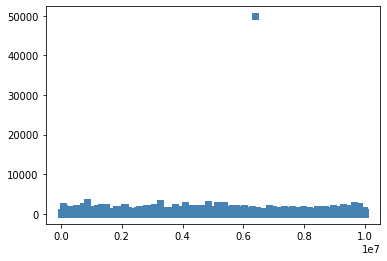

<Figure size 432x288 with 0 Axes>

In [169]:
plt.scatter(df.userid, df["sum_gamerounds"], c = "steelblue", marker = "s")
plt.figure()

<Figure size 432x288 with 0 Axes>

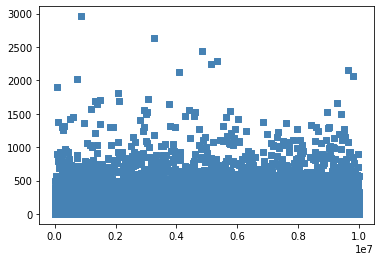

<Figure size 432x288 with 0 Axes>

In [170]:
# После исключения выброса по полю sum_gamerounds <4000 распределение значений имеет более красивый вид
df = df[df["sum_gamerounds"]<4000]
plt.scatter(df.userid, df["sum_gamerounds"], c = "steelblue", marker = "s")
plt.figure()

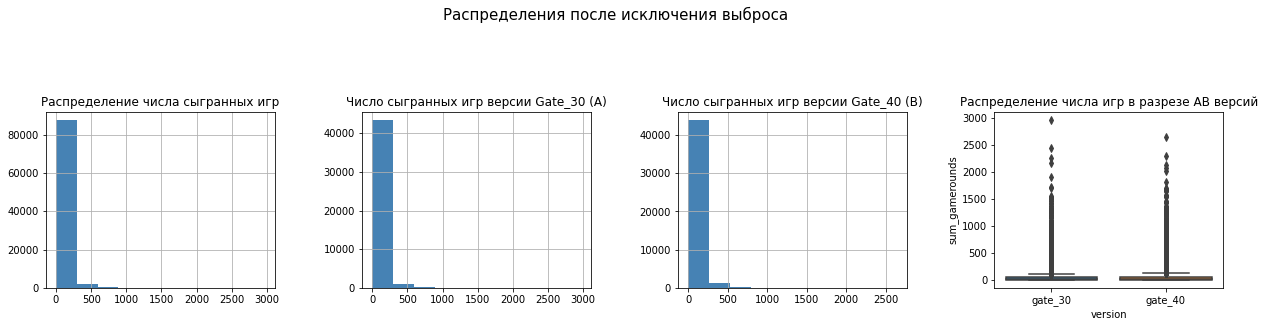

In [171]:
fig, axes = plt.subplots(1, 4, figsize = (18,5))
df.sum_gamerounds.hist(ax = axes[0], color = "steelblue")
df[(df.version == "gate_30")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
df[(df.version == "gate_40")].hist("sum_gamerounds", ax = axes[2], color = "steelblue")
sns.boxplot(x = df.version, y = df.sum_gamerounds, ax = axes[3])

plt.suptitle("Распределения после исключения выброса", fontsize = 15)
axes[0].set_title("Распределение числа сыгранных игр", fontsize = 12)
axes[1].set_title("Число сыгранных игр версии Gate_30 (A)", fontsize = 12)
axes[2].set_title("Число сыгранных игр версии Gate_40 (B)", fontsize = 12)
axes[3].set_title("Распределение числа игр в разрезе AB версий", fontsize = 12)

plt.tight_layout(pad = 4);

In [172]:
# Есть наблюдения с нулевым числом сыгранных раундов, но имеющих положительную метку retention. Возможно они не доиграли 1 раунд игры
# Лучше такие наблюдения исключить, они не должны влиять на процент удержания игроков (таких в выборке 111 строк)
df.loc[(df["sum_gamerounds"] == 0) & ((df["retention_1"] == True) | (df["retention_7"] == True))].shape[0]

111

In [173]:
df.loc[(df["sum_gamerounds"] == 0) & ((df["retention_1"] == True) | (df["retention_7"] == True))]

,userid,version,sum_gamerounds,retention_1,retention_7
1000,110479,gate_30,0,False,True
1872,203165,gate_30,0,True,False
2330,257330,gate_30,0,True,False
2803,307703,gate_40,0,True,True
3994,442819,gate_30,0,True,False
...,...,...,...,...,...
86779,9616345,gate_40,0,True,False
87635,9708844,gate_30,0,True,False
87973,9750017,gate_40,0,True,False
88671,9830174,gate_40,0,True,False


In [174]:
df = df.drop(df[(df["sum_gamerounds"] == 0) & ((df["retention_1"] == True) | (df["retention_7"] == True))].index)
df.shape[0]

90077

### Анализ поведения игроков двух групп

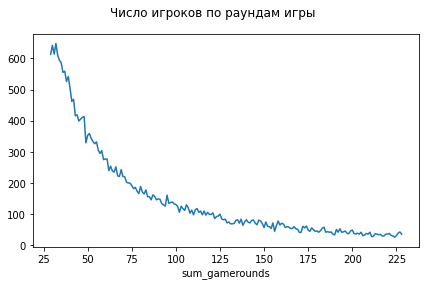

In [182]:
# Большая часть игроков не доходит до 50 уровня игры
df.groupby("sum_gamerounds").userid.count()[:200].plot()
plt.suptitle("Число игроков по раундам игры", fontsize = 12)
plt.tight_layout(pad=1);

In [175]:
#Половина игроков играла не более 17 раундов игр, 
# вопрос в том, как считается sum_gamerounds и нужно ли исключать тех, у кого число раундов меньше 30, на которых показываются "ворота"
# Т.к есть игроки, играющие больше 2 тыс. sum_gamerounds в неделю, будем предполагать, что это раунды игры в т.ч. непройденные
# Т.е. юзеры, которые сыграли меньше 30 раундов и соответственно 30 уровня до показа ворот вообще не доходили, таких далее будем исключать из анализа
df.describe([0.01, 0.05, 0.10, 0.20, 0.75, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,75%,80%,90%,95%,99%,max
sum_gamerounds,90077.0,51.383494,102.730152,0.0,0.0,1.0,1.0,4.0,17.0,51.0,67.0,135.0,221.0,493.0,2961.0


In [218]:
df = df.drop(df[df["sum_gamerounds"] < 29].index)
df.shape[0]

33881

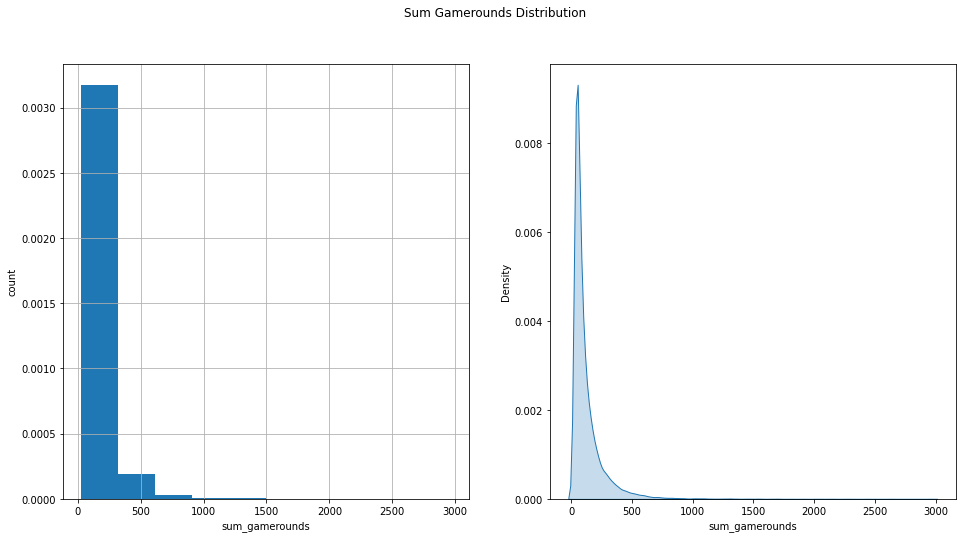

In [219]:
# Даже после исключения игроков, сыгравших менее 30 раундов, распределение числа сыгранных игр имеет значительное смещение влево
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['sum_gamerounds'].hist(density=True)
plt.ylabel('count')
plt.xlabel('sum_gamerounds')

plt.subplot(122)
sns.kdeplot(df['sum_gamerounds'], shade=True, legend=False)
plt.xlabel('sum_gamerounds')

plt.suptitle('Sum Gamerounds Distribution')
plt.show()

In [220]:
# После исключения игроков не дошедших до показа "ворот" осталось 33.8 тыс.наблюдений со следующим распределением числа раундов:
df.describe([0.01, 0.05, 0.10, 0.20, 0.75, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,75%,80%,90%,95%,99%,max
sum_gamerounds,33881.0,121.572327,141.640065,29.0,29.0,31.0,34.0,40.0,72.0,142.0,167.0,265.0,375.0,696.0,2961.0


In [221]:
# По числу игроков двух анализируемых групп (тестовой и контрольной) - выборка сбалансирована
df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,16957,70,120.434688,140.235673,2961
gate_40,16924,74,122.712184,143.028435,2640


In [180]:
# По метрике retention_1 группы А и В выглядят очень похожими по среднему и медианному числу сыгранных игр 
# При этом показатель среднего числа сыгранных игр несколько выше в тестовой группе В 
df.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version retention_1                                             
gate_30 False         3439      47   72.612387   74.861408  1072
        True         13518      80  132.600755  150.047305  2961
gate_40 False         3399      51   75.279494   72.934966  1241
        True         13525      83  134.632606  153.474798  2640

In [181]:
# По метрике retention_7 группы А и В также выглядят очень похожими по основным стат. метрикам числа игр 
# Показатель среднего числа сыгранных игр также несколько выше в тестовой группе В 
df.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version retention_7                                             
gate_30 False         9598      51   72.828714   62.482521   981
        True          7359     126  182.524935  182.797674  2961
gate_40 False         9743      54   74.112080   64.910153  2640
        True          7181     130  188.651581  186.939183  2294

In [183]:
# Создадим признак - возвращение в приложение и либо на 1 либо на 7 день после установки игры (т.е. кто показал какую-то активность)
df['retention'] = False
retention =( (df['retention_1'] == True) | (df['retention_7'] == True) )
df.loc[retention, 'retention'] = True

In [184]:
# У таких игроков отличия между А и В группой по среднему и медианному числу сыгранных игр также не выражены явно
df.groupby(["version", "retention"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version retention                                             
gate_30 False       2256      41   55.393617   47.166415   981
        True       14701      79  130.415822  146.949156  2961
gate_40 False       2273      44   57.795864   42.210078   547
        True       14651      82  132.783496  150.331438  2640

In [185]:
# Создадим признак - полное описание поведения игрока на 1 и на 7 день
df["retention_full"] = list(map(lambda x,y: str(x)+"-"+str(y), df.retention_1, df.retention_7))
df.groupby(["version", "retention_full"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index()

,version,retention_full,count,median,mean,std,max
0,gate_30,False-False,2256,41,55.393617,47.166415,981
1,gate_30,False-True,1183,70,105.448859,102.036326,1072
2,gate_30,True-False,7342,55,78.186053,65.561791,918
3,gate_30,True-True,6176,140,197.288698,190.964802,2961
4,gate_40,False-False,2273,44,57.795864,42.210078,547
5,gate_40,False-True,1126,77,110.572824,102.979262,1241
6,gate_40,True-False,7470,58,79.076841,69.626894,2640
7,gate_40,True-True,6055,145,203.171263,195.270672,2294


#### Так как основной метрикой все-таки является удержание игрока, а не общее или среднее число сыгранных игр, далее для анализа будем использовать именно retention
Выбор в пользу анализа коэф. удержания игрока на 7 день основывается на том, что по условию задачи ворота (Cat Gates) в текущей 
версии игры только на 30 уровне и большая часть игроков их просто не достигнет, играя всего 1 день.

In [207]:
#Показатель retention_7 в среднем при воротах на 30 уровне несколько выше, чем при их перемещении на 40 уровень
df.groupby('version')['retention_7'].mean()

version
gate_30    0.433980
gate_40    0.424309
Name: retention_7, dtype: float64

<AxesSubplot:ylabel='Density'>

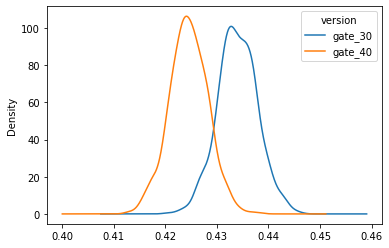

In [187]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(1000):
    boot_mean = df.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

boot_7d.plot(kind='density')

Вероятность, что retention_7 выше в версии игры gate_30: 0.962


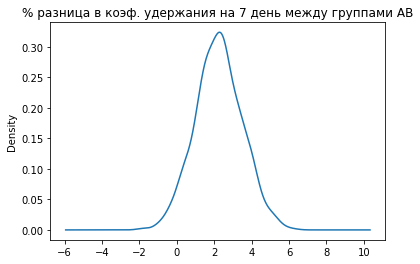

In [222]:
# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40)/boot_7d.gate_40*100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind='density')
ax.set_title('% разница в коэф. удержания на 7 день между группами АВ')

# Из графика видно, что наиболее вероятная разница в % составляет около 2%
# и что ~ 96% распределения выше 0% в пользу ворот на уровне 30
print('Вероятность, что retention_7 выше в версии игры gate_30:',(boot_7d['diff'] > 0).mean())

### Проверка гипотезы о равенстве retention rate двух групп 
Выберем 95% уровень достоверности и проверим гипотезу, что коэф. удержания игроков в группах АВ все-таки равны

- H0: mu(A retention_7) == mu(B retention_7)

- H1: mu(A retention_7) > mu(B retention_7) исходя из выводов о среднем retention rate выше

In [223]:
# Так как после исключения игроков с числом раундов < 30 осталось всего 33.8 тыс. наблюдений, 
# для проверки гипотезы о равенстве средних выберем 10 тыс. наблюдений из каждой группы
required_n = 10000
control_sample = df[df['version'] == 'gate_30'].sample(n=required_n, random_state=42)
treatment_sample = df[df['version'] == 'gate_40'].sample(n=required_n, random_state=42)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [224]:
ab_test['version'].value_counts()

gate_40    10000
gate_30    10000
Name: version, dtype: int64

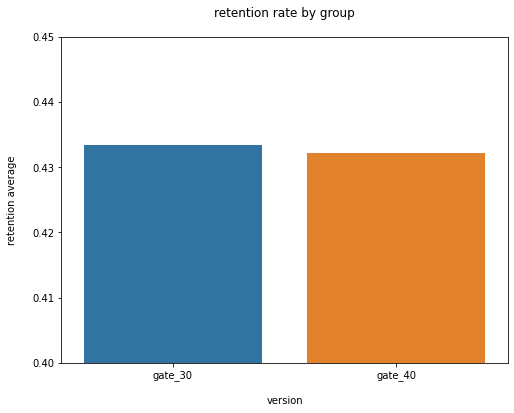

In [210]:
# На графике видно, что коэф. удержания игрока в среднем выше в текущей версии игры (gate_30)
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], y=ab_test['retention_7'], ci=False)

plt.ylim(0.4, 0.45)
plt.title('retention rate by group', pad=20)
plt.xlabel('version', labelpad=15)
plt.ylabel('retention average', labelpad=15);

In [196]:
# Вычислим процент игроков, активных на.7 день, в каждой из групп (rate_a, rate_b)
num_a, num_b = control_sample['version'].value_counts()[0], treatment_sample['version'].value_counts()[0]
retention_a  = control_sample.loc[control_sample["retention_7"] == True].shape[0] 
retention_b = treatment_sample.loc[treatment_sample["retention_7"] == True].shape[0]
rate_a = retention_a / num_a
rate_b  = retention_b / num_b

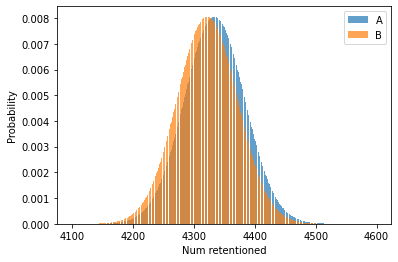

In [206]:
# Метрика true/false представляет собой биномиальное распределение, зададим число удержанных игоков и построим распределение вероятности

from scipy.stats import binom
clicks = np.arange(4100, 4600)
prob_a = binom(num_a, rate_a).pmf(clicks)
prob_b = binom(num_b, rate_b).pmf(clicks)

plt.bar(clicks, prob_a, label="A", alpha=0.7)
plt.bar(clicks, prob_b, label="B", alpha=0.7)
plt.legend()
plt.xlabel("Num retentioned"); plt.ylabel("Probability");

Распределения двух групп практически накладываются друг на друга и не имеют ярко выраженного отличия напр. по среднему значению

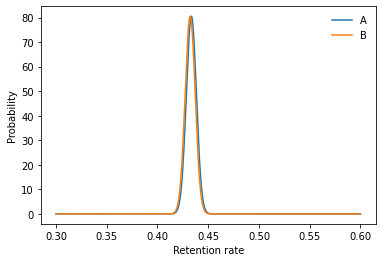

In [204]:
# Исходя из центральной предельной теоремы и достаточного числа наблюдений можем предположить, что
# окончательная оценка среднего коэф. удержания игрока можно аппроксимировать нормальным распределением со стандартной ошибкой, равной
# std = sqrt(p(1-p)/n) sourse:https://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation
from scipy.stats import norm

std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)

click_rate = np.linspace(0.3, 0.6, 4000)
prob_a = norm(rate_a, std_a).pdf(click_rate)
prob_b = norm(rate_b, std_b).pdf(click_rate)

plt.plot(click_rate, prob_a, label="A")
plt.plot(click_rate, prob_b, label="B")
plt.legend(frameon=False)
plt.xlabel("Retention rate"); plt.ylabel("Probability");

zscore is 0.171, with p-value 0.432


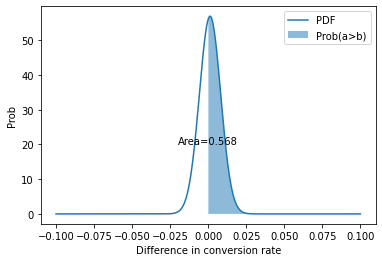

In [225]:
# Разность нормально распределенных случайных величин также является нормально распределенной величиной
# со средним, равным разности средних, ст. отклонением равным корню из суммы дисперсий 
z_score = (rate_a - rate_b) / np.sqrt(std_a**2 + std_b**2)
#поменять местами а и в, если H1 гипотеза о том, что В лучше А
p = norm(rate_a - rate_b, np.sqrt(std_a**2 + std_b**2))

x = np.linspace(-0.1, 0.1, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.plot(x, y, label="PDF")
#поменять местами а и в, если H1 гипотеза о том, что В лучше А
plt.fill_between(x, 0, y, where=x>0, label="Prob(a>b)", alpha=0.5)
plt.annotate(f"Area={area_under_curve:0.3f}", (-0.02, 20))
plt.legend()
plt.xlabel("Difference in conversion rate"); plt.ylabel("Prob");

print(f"zscore is {z_score:0.3f}, with p-value {norm().sf(z_score):0.3f}")

p value больше 5%, нулевая гипотеза о равенстве retention rate для тестовой и проверочной групп не отклоняется
Можем ожидать, что в 43% выбранных случаев retention_rate по группе А не будет отличаться от retention_rate по группе В

In [226]:
def get_confidence_ab_test(retention_a, num_a, retention_b, num_b):
    rate_a = retention_a / num_a
    rate_b = retention_b / num_b
    std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
    std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)
    #поменять местами а и в, если H1 гипотеза о том, что В лучше А
    z_score = (rate_a - rate_b) / np.sqrt(std_a**2 + std_b**2)
    return norm.cdf(z_score)

print(get_confidence_ab_test(retention_a, num_a, retention_b, num_b))

0.5679901623357617


In [203]:
from scipy.stats import mannwhitneyu
a_dist = np.zeros(num_a)
a_dist[:retention_a] = 1
b_dist = np.zeros(num_b)
b_dist[:retention_b] = 1
stat, p_value = mannwhitneyu(a_dist, b_dist, alternative="greater")
#поменять greater на less, если H1 гипотеза о том, что В лучше А
print(f"Mann-Whitney U test for null hypothesis A >= B is {p_value:0.3f}")
# p-value is low and we can reject the null hypthesis о равенстве среднего процента удержания

Mann-Whitney U test for null hypothesis A >= B is 0.432


In [215]:
# Посчитаем доверительные интервалы retantion rate для двух групп
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['version'] == 'gate_30']['retention_7']
treatment_results = ab_test[ab_test['version'] == 'gate_40']['retention_7']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.17
p-value: 0.864
ci 95% for control group: [0.424, 0.443]
ci 95% for treatment group: [0.422, 0.442]


#### Так как p-value по всем проведенным тестам выше α=0.05, гипотезу о равенстве средних по двум группам нельзя отклонить
#### и перемещение ворот на 40 уровень игры не дает целевого прироста по коэф. удержания игрока.